In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import pandas as pd

import matplotlib.pyplot as plt


In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: 

In [ ]:
df=pd.read_csv('spotify_churn_dataset.csv')
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [ ]:
df.isna().sum()

,0
user_id,0
gender,0
age,0
country,0
subscription_type,0
listening_time,0
songs_played_per_day,0
skip_rate,0
device_type,0
ads_listened_per_week,0


In [ ]:
X = df.drop(columns=['is_churned', 'user_id'])
y = df['is_churned']

# Division du jeu de données en apprentissage et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:

colonnes_categorielles = ['gender', 'country', 'subscription_type',
                          'device_type', 'offline_listening']

colonnes_numeriques = ['age', 'listening_time', 'songs_played_per_day',
                       'skip_rate', 'ads_listened_per_week']

preprocesseur = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), colonnes_categorielles),
        ('num', StandardScaler(), colonnes_numeriques)
    ])


In [ ]:

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)


In [ ]:

#  Distribution aléatoire des hyperparamètres à tester
parametres_xgb = {
    "classificateur__n_estimators": randint(100, 500),      # nombre d’arbres
    "classificateur__learning_rate": uniform(0.001, 0.5),   # taux d’apprentissage
    "classificateur__max_depth": randint(2, 15),            # profondeur maximale
    "classificateur__subsample": uniform(0.5, 0.5),         # sous-échantillonnage des lignes
    "classificateur__colsample_bytree": uniform(0.5, 0.5)   # sous-échantillonnage des colonnes
}


In [ ]:

#  Pipeline complet avec SMOTE (équilibrage des classes)
# SMOTE permet de générer artificiellement des observations pour la classe minoritaire
pipeline_xgb = ImbPipeline([
    ('preprocesseur', preprocesseur),
    ('smote', SMOTE(random_state=42)),
    ('classificateur', xgb_model)
])

In [ ]:

#  Recherche aléatoire d’hyperparamètres (Randomized Search)
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=parametres_xgb,
    n_iter=10,                  # nombre d’itérations de recherche
    cv=5,                       # validation croisée à 5 plis
    n_jobs=-1,                  # exécution parallèle
    scoring='f1_weighted',      # score basé sur le F1 pondéré (utile pour classes déséquilibrées)
    random_state=42,
    verbose=1
)


In [ ]:
print(" Optimisation des hyperparamètres XGBoost en cours...")
random_search_xgb.fit(X_train, y_train)
print(" Meilleurs hyperparamètres XGBoost :", random_search_xgb.best_params_)


 Optimisation des hyperparamètres XGBoost en cours...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [00:50:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Meilleurs hyperparamètres XGBoost : {'classificateur__colsample_bytree': np.float64(0.5780093202212182), 'classificateur__learning_rate': np.float64(0.07899726016810132), 'classificateur__max_depth': 12, 'classificateur__n_estimators': 187, 'classificateur__subsample': np.float64(0.6668543055695109)}


In [ ]:

#  Entraînement final avec le meilleur modèle
xgb_optimal = random_search_xgb.best_estimator_
y_pred = xgb_optimal.predict(X_test)
y_prob = xgb_optimal.predict_proba(X_test)[:, 1]


In [ ]:

# Évaluation du modèle
resultats_xgb = {
    "Exactitude (Accuracy)":  accuracy_score(y_test, y_pred),
    "Précision (Precision)":  precision_score(y_test, y_pred, average='weighted', zero_division=0),
    "Rappel (Recall)":        recall_score(y_test, y_pred, average='weighted', zero_division=0),
    "Score F1":               f1_score(y_test, y_pred, average='weighted', zero_division=0),
    "ROC-AUC":                roc_auc_score(y_test, y_prob)
}


In [ ]:


# Conversion en DataFrame pour affichage clair
resultats_xgb_df = pd.DataFrame([resultats_xgb], index=["XGBoost"])
print("\n Résultats finaux du modèle XGBoost :")
print(resultats_xgb_df)



 Résultats finaux du modèle XGBoost :
         Exactitude (Accuracy)  Précision (Precision)  Rappel (Recall)  \
XGBoost                  0.715               0.657237            0.715   

         Score F1  ROC-AUC  
XGBoost  0.668754  0.52881  


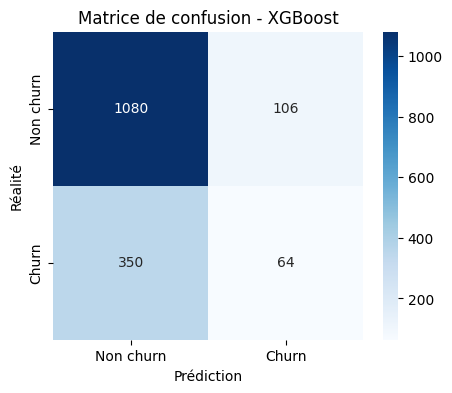

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non churn', 'Churn'],
            yticklabels=['Non churn', 'Churn'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion - XGBoost')
plt.show()


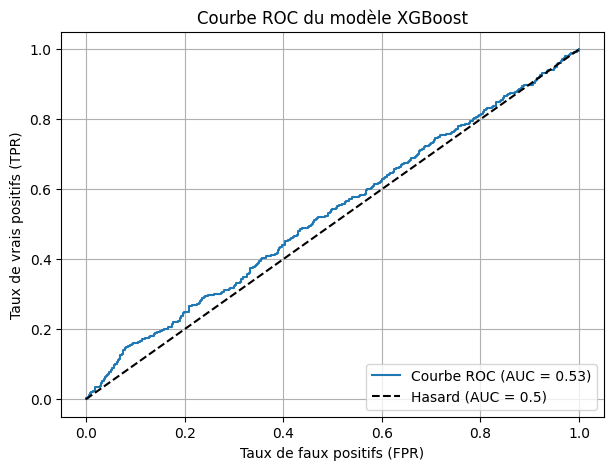

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcul des taux de faux/vrais positifs
fpr, tpr, seuils = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Hasard (AUC = 0.5)')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC du modèle XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
